In [1]:
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
infection_features = ['-polys','WBC x 1000','CRP']
df_fea = pd.read_csv("/public/hanl/jupyter_dir/database/eicu/raw/raw/lab.csv")
df_fea = df_fea[df_fea["labname"].isin(infection_features)]
df_fea = df_fea[['patientunitstayid', 'labresultoffset', 'labname','labresult','labmeasurenamesystem']]
df_fea.columns = ["stay_id","charttime",'labname','labresult','unit']
df_fea = df_fea.groupby(['stay_id', 'charttime', 'labname']).agg({'labresult': 'mean'}).unstack('labname').reset_index()
df_fea.columns  =[ 'stay_id',"charttime" ,'neutrophils','crp','wbc']
# df_fea["crp"] = df_fea["crp"]*10
df_fea["charttime"] = df_fea["charttime"]/60
df_fea.head()

,stay_id,charttime,neutrophils,crp,wbc
0,141168,8.600000,61.0,NaN,9.8
1,141168,18.883333,80.0,NaN,14.7
2,141168,33.766667,78.0,NaN,19.8
3,141178,-4.666667,45.0,NaN,7.6
4,141179,24.783333,NaN,NaN,8.1


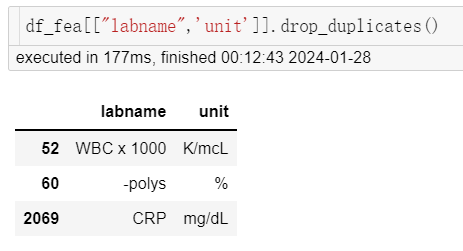

In [3]:
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/03.eICU_SAKI_trajCluster/df_mixAK_fea4_C3_eicu.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("纳入患者数量：",len(all_lst))

df_type_filt["groupHPD"].value_counts()

纳入患者数量： 1417


2    869
1    423
3    125
Name: groupHPD, dtype: int64

In [4]:
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_eicu///disease_definition/AKI/eicu_saki_event_time.csv")
df_time = df_time[["stay_id","saki_onset"]]
df_time = df_time[df_time["stay_id"].isin(all_lst)]
df_time.head(1)

,stay_id,saki_onset
15049,291577,8.0


In [5]:
#  condition1: -4 <= time <= 28
df_fea_add = pd.merge(df_fea, df_time, how="inner", on="stay_id")
df_fea_add["time"] = (df_fea_add["charttime"] - df_fea_add["saki_onset"])/24
df_fea_add["time"] = df_fea_add["time"].map(lambda x:x//1) # -1指sepsis前6小时的数据，0指sepsis后第一个6小时的数据
df_fea_add["time"] = df_fea_add["time"].map(lambda x: x+1 if x>=0 else x)
df_fea_add = df_fea_add[(df_fea_add["time"]>=-2) &(df_fea_add["time"]<=7)]
df_fea_add = df_fea_add.drop(["charttime","saki_onset"],axis=1)
df_fea_add = df_fea_add.groupby(["stay_id","time"]).agg( "mean" ).reset_index()
df_fea_add = df_fea_add[df_fea_add.stay_id.isin(all_lst)]
df_fea_add.head(1)

,stay_id,time,neutrophils,crp,wbc
0,243208,-1.0,55.0,NaN,13.8


In [6]:
# 前向插补
tmp_df = pd.DataFrame()
df_fea_add = df_fea_add.sort_values(by=["stay_id","time"])
for i,j in df_fea_add.groupby(["stay_id"]):
    j = j.fillna(method="ffill")
    j = j.fillna(method="bfill")
    tmp_df = pd.concat([tmp_df, j], axis=0)
df_im = tmp_df
df_im = df_im.reset_index()
df_im.to_csv("df_infection_feature.csv",index=False)
df_im.isna().sum()

<ipython-input-6-28d4b8720dc9>:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i,j in df_fea_add.groupby(["stay_id"]):


index             0
stay_id           0
time              0
neutrophils    1257
crp            6965
wbc               0
dtype: int64